## General information

In this kernel I'll try various technics for models interpretability and feature selection. Also I'll compare various models.

I use the features from my dataset: https://www.kaggle.com/artgor/lanl-features

This dataset was created using this kernel: https://www.kaggle.com/artgor/even-more-features/

**UPD**: Thanks to the new kaggle update we can write code in kernels and import it. This is much more convenient and useful.
I'm moving all the functions I can into this script: https://www.kaggle.com/artgor/artgor-utils
So if you see somewhere code like `artgot_utils.function_name(parameters)` - it is from this script

![](https://torontoseoulcialite.com/wp-content/uploads/2016/02/zimbiocom.jpg)

In [1]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler
from sklearn.svm import NuSVR, SVR
from sklearn.metrics import mean_absolute_error
pd.options.display.precision = 15
from sklearn.model_selection import train_test_split, KFold, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn import svm
import lightgbm as lgb
import xgboost as xgb
import time
import datetime
from catboost import CatBoostRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn import neighbors
from sklearn.metrics import mean_absolute_error
from sklearn import linear_model
import gc
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from sklearn.ensemble import ExtraTreesRegressor, AdaBoostRegressor

from scipy.signal import hilbert
from scipy.signal import hann
from scipy.signal import convolve
from scipy import stats
from sklearn.kernel_ridge import KernelRidge
from sklearn.neighbors import NearestNeighbors
import librosa, librosa.display
import builtins
from sklearn.ensemble import RandomForestRegressor
import eli5
import shap
from sklearn.feature_selection import GenericUnivariateSelect, SelectPercentile, SelectKBest, f_classif, mutual_info_classif, RFE

from IPython.display import HTML
import json
import altair as alt

import artgor_utils


# setting up altair
workaround = artgor_utils.prepare_altair()
HTML("".join((
    "<script>",
    workaround,
    "</script>",
)))

In [2]:
os.listdir('../input/lanl-features')

['submission_1.csv',
 'sample_submission.csv',
 'train_features.csv',
 'test_features.csv',
 'test_features_denoised.csv',
 'train_features_denoised.csv',
 'y.csv']

* 'train_features.csv' - train features generated on original data
* 'train_features_denoised.csv' - train features generated on denoised data
* 'test_features.csv' - test features generated on original data
* 'test_features_denoised.csv' - test features generated on denoised data
* 'submission_1.csv' - one of my local submissions
* 'y.csv' - train target

## Loading data
Let's load features!

In [3]:
train_features = pd.read_csv('../input/lanl-features/train_features.csv')
test_features = pd.read_csv('../input/lanl-features/test_features.csv')
train_features_denoised = pd.read_csv('../input/lanl-features/train_features_denoised.csv')
test_features_denoised = pd.read_csv('../input/lanl-features/test_features_denoised.csv')
train_features_denoised.columns = [f'{i}_denoised' for i in train_features_denoised.columns]
test_features_denoised.columns = [f'{i}_denoised' for i in test_features_denoised.columns]
y = pd.read_csv('../input/lanl-features/y.csv')

In [4]:
X = pd.concat([train_features, train_features_denoised], axis=1).drop(['seg_id_denoised', 'target_denoised'], axis=1)
X_test = pd.concat([test_features, test_features_denoised], axis=1).drop(['seg_id_denoised', 'target_denoised'], axis=1)
X = X[:-1]
y = y[:-1]

We have almost 2000 features here!

In [5]:
n_fold = 10
folds = KFold(n_splits=n_fold, shuffle=True, random_state=2019)

## Basic model

Training function is imported from my script. Important changes from the code, which I used previously:
- function returns dictionary with oof, test predictions and scores. Also with feature importances, if necessary;
- in future it will be easier to change metrics.

Fold 1 started at Thu May 23 16:00:09 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[618]	training's l1: 1.28917	valid_1's l1: 1.92724
Fold 2 started at Thu May 23 16:00:15 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[978]	training's l1: 1.00668	valid_1's l1: 2.07546
Fold 3 started at Thu May 23 16:00:22 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[647]	training's l1: 1.26053	valid_1's l1: 2.00919
Fold 4 started at Thu May 23 16:00:28 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[196]	training's l1: 1.78144	valid_1's l1: 2.07919
Fold 5 started at Thu May 23 16:00:31 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[373]	training's l1: 1.53651	valid_1's l1: 2.05188
Fold 6 started at Thu May 23 16:00:36 20

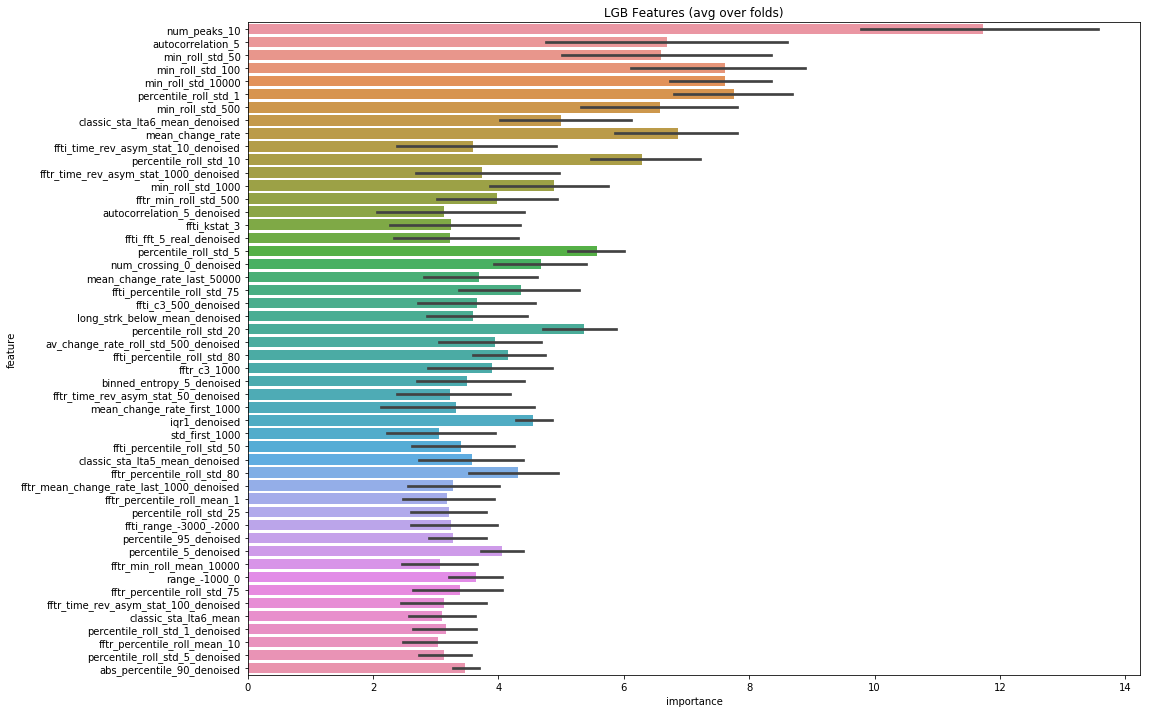

In [6]:
params = {'num_leaves': 128,
          'min_child_samples': 79,
          'objective': 'gamma',
          'max_depth': -1,
          'learning_rate': 0.01,
          "boosting_type": "gbdt",
          "subsample_freq": 5,
          "subsample": 0.9,
          "bagging_seed": 11,
          "metric": 'mae',
          "verbosity": -1,
          'reg_alpha': 0.13,
          'reg_lambda': 0.36,
          'colsample_bytree': 0.1
         }
result_dict_lgb = artgor_utils.train_model_regression(X=X, X_test=X_test, y=y, params=params, folds=folds, model_type='lgb',
                                                                                  eval_metric='mae', plot_feature_importance=True)

In [7]:
submission = pd.read_csv('../input/lanl-features/sample_submission.csv', index_col='seg_id')
submission['time_to_failure'] = result_dict_lgb['prediction']
# print(submission.head())
# submission.to_csv('submission.csv')

In [8]:
# sub1 = pd.read_csv('../input/lanl-features/submission_1.csv')
# sub1.to_csv('submission_1.csv', index=False)

## NN features
Here I normalize the data and create features using NearestNeighbors. The idea is to find samples which are similar and use it to generate features.

In [9]:
scaler = StandardScaler()
scaler.fit(X)
X_train_scaled = pd.DataFrame(scaler.transform(X), columns=X.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

In [10]:
%%time
n = 10
neigh = NearestNeighbors(n, n_jobs=-1)
neigh.fit(X_train_scaled)

dists, _ = neigh.kneighbors(X_train_scaled, n_neighbors=n)
mean_dist = dists.mean(axis=1)
max_dist = dists.max(axis=1)
min_dist = dists.min(axis=1)

X_train_scaled['mean_dist'] = mean_dist
X_train_scaled['max_dist'] = max_dist
X_train_scaled['min_dist'] = min_dist

test_dists, _ = neigh.kneighbors(X_test_scaled, n_neighbors=n)

test_mean_dist = test_dists.mean(axis=1)
test_max_dist = test_dists.max(axis=1)
test_min_dist = test_dists.min(axis=1)

X_test_scaled['mean_dist'] = test_mean_dist
X_test_scaled['max_dist'] = test_max_dist
X_test_scaled['min_dist'] = test_min_dist


CPU times: user 3min 10s, sys: 189 ms, total: 3min 10s
Wall time: 14.8 s


Fold 1 started at Thu May 23 16:01:19 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[866]	training's l1: 1.16161	valid_1's l1: 1.93217
Fold 2 started at Thu May 23 16:01:25 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1125]	training's l1: 0.992207	valid_1's l1: 2.08628
Fold 3 started at Thu May 23 16:01:32 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[727]	training's l1: 1.26218	valid_1's l1: 2.01798
Fold 4 started at Thu May 23 16:01:38 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[245]	training's l1: 1.7393	valid_1's l1: 2.06878
Fold 5 started at Thu May 23 16:01:41 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[329]	training's l1: 1.63745	valid_1's l1: 2.05038
Fold 6 started at Thu May 23 16:01:45 2

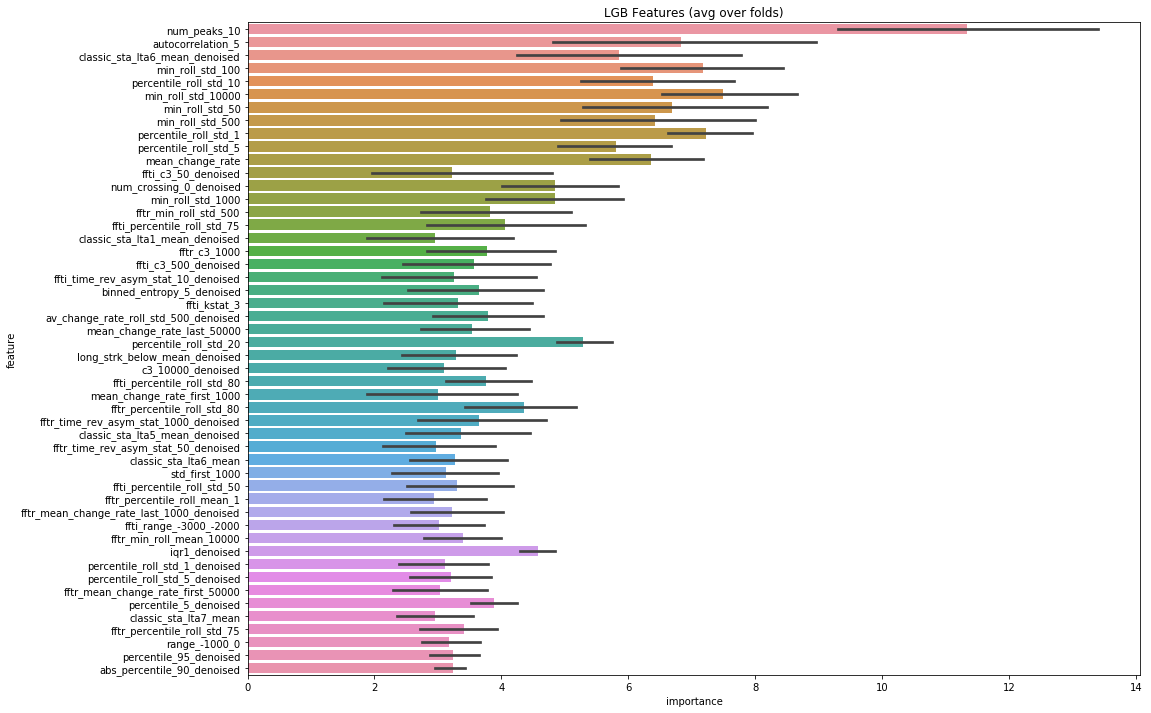

In [11]:
params = {'num_leaves': 32,
          'min_data_in_leaf': 79,
          'objective': 'gamma',
          'max_depth': -1,
          'learning_rate': 0.01,
          "boosting": "gbdt",
          "bagging_freq": 5,
          "bagging_fraction": 0.8126672064208567,
          "bagging_seed": 11,
          "metric": 'mae',
          "verbosity": -1,
          'reg_alpha': 0.13,
          'reg_lambda': 0.36,
          'feature_fraction': 0.1
         }
result_dict_lgb = artgor_utils.train_model_regression(X=X, X_test=X_test, y=y, params=params, folds=folds, model_type='lgb',
                                                                                  eval_metric='mae', plot_feature_importance=True)

In [12]:
# submission['time_to_failure'] = result_dict_lgb['prediction']
# submission.to_csv('submission_nn.csv')

## Model interpretation


### ELI5 and permutation importance
ELI5 is a package with provides explanations for ML models. It can do this not only for linear models, but also for tree based like Random Forest or lightgbm.

**Important notice**: running eli5 on all features takes a lot of time, so I run the cell below in `version 14` and printed the top-50 features. In the following versions I'll use these 50 columns and use eli5 to find top-40 of them so that it takes less time

In [13]:
top_columns = ['iqr1_denoised', 'percentile_5_denoised', 'abs_percentile_90_denoised', 'percentile_95_denoised', 'ave_roll_std_10', 'num_peaks_10', 'percentile_roll_std_20',
               'ratio_unique_values_denoised', 'fftr_percentile_roll_std_75_denoised', 'num_crossing_0_denoised', 'percentile_95', 'ffti_percentile_roll_std_75_denoised',
               'min_roll_std_10000', 'percentile_roll_std_1', 'percentile_roll_std_10', 'fftr_percentile_roll_std_70_denoised', 'ave_roll_std_50', 'ffti_percentile_roll_std_70_denoised',
               'exp_Moving_std_300_mean_denoised', 'ffti_percentile_roll_std_30_denoised', 'mean_change_rate', 'percentile_roll_std_5', 'range_-1000_0', 'mad',
               'fftr_range_1000_2000_denoised', 'percentile_10_denoised', 'ffti_percentile_roll_std_80', 'percentile_roll_std_25', 'fftr_percentile_10_denoised',
               'ffti_range_-2000_-1000_denoised', 'autocorrelation_5', 'min_roll_std_100', 'fftr_percentile_roll_std_80', 'min_roll_std_500', 'min_roll_std_50', 'min_roll_std_1000',
               'ffti_percentile_20_denoised', 'iqr1', 'classic_sta_lta5_mean_denoised', 'classic_sta_lta6_mean_denoised', 'percentile_roll_std_10_denoised',
               'fftr_percentile_70_denoised', 'ffti_c3_50_denoised', 'ffti_percentile_roll_std_75', 'abs_percentile_90', 'range_0_1000', 'spkt_welch_density_50_denoised',
               'ffti_percentile_roll_std_40_denoised', 'ffti_range_-4000_-3000', 'mean_change_rate_last_50000']


X_train, X_valid, y_train, y_valid = train_test_split(X[top_columns], y, test_size=0.1)
model = lgb.LGBMRegressor(**params, n_estimators = 50000, n_jobs = 8, verbose=-1)
model.fit(X_train, y_train, 
        eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric='mae',
        verbose=10000, early_stopping_rounds=200)

perm = eli5.sklearn.PermutationImportance(model, random_state=1).fit(X_train, y_train)

Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[680]	training's l1: 1.71765	valid_1's l1: 2.0992


In [14]:
eli5.show_weights(perm, top=50, feature_names=top_columns)

Weight,Feature
0.0411 ± 0.0062,num_crossing_0_denoised
0.0283 ± 0.0052,num_peaks_10
0.0170 ± 0.0035,abs_percentile_90_denoised
0.0165 ± 0.0006,percentile_roll_std_10
0.0145 ± 0.0022,percentile_roll_std_5
0.0143 ± 0.0009,percentile_roll_std_1
0.0134 ± 0.0022,iqr1_denoised
0.0131 ± 0.0018,min_roll_std_50
0.0128 ± 0.0013,min_roll_std_500
0.0119 ± 0.0020,percentile_5_denoised


Fold 1 started at Thu May 23 16:02:20 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[569]	training's l1: 1.79822	valid_1's l1: 1.95995
Fold 2 started at Thu May 23 16:02:20 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[916]	training's l1: 1.65959	valid_1's l1: 2.08176
Fold 3 started at Thu May 23 16:02:21 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[842]	training's l1: 1.69646	valid_1's l1: 2.03352
Fold 4 started at Thu May 23 16:02:21 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[278]	training's l1: 1.93256	valid_1's l1: 2.10041
Fold 5 started at Thu May 23 16:02:21 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[393]	training's l1: 1.87212	valid_1's l1: 2.0689
Fold 6 started at Thu May 23 16:02:22 201

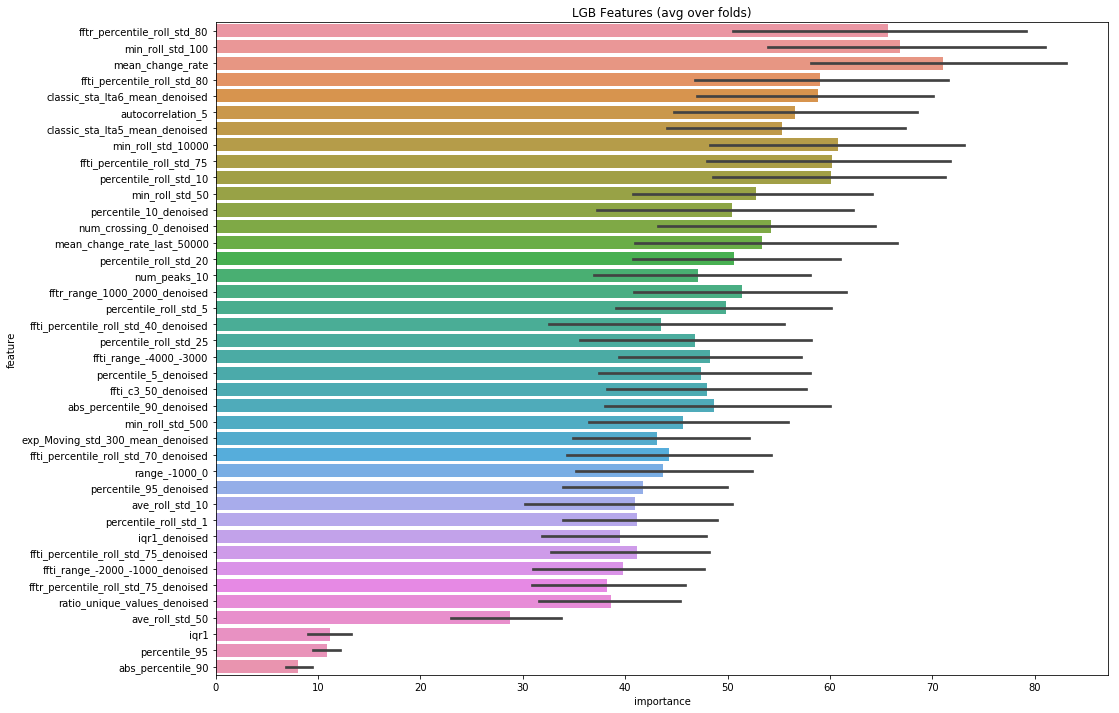

In [15]:
top_features = [i for i in eli5.formatters.as_dataframe.explain_weights_df(model).feature if 'BIAS' not in i][:40]
result_dict_lgb = artgor_utils.train_model_regression(X, X_test, y, params=params, folds=folds, model_type='lgb', plot_feature_importance=True, columns=top_features)

In [16]:
# submission['time_to_failure'] = result_dict_lgb['prediction']
# submission.to_csv('submission_eli5.csv')

## Feature selection

Here I try various approaches to feature selection.

**Important notice**: running feature selection on all features takes a lot of time, so I'll run some of feature selection methods and print the result, which I'll use in the following versions of the kernel, so that I can explore more approaches.

In [17]:
params = {'num_leaves': 32,
          'min_child_samples': 79,
          'objective': 'gamma',
          'max_depth': -1,
          'learning_rate': 0.01,
          "boosting_type": "gbdt",
          "subsample_freq": 5,
          "subsample": 0.9,
          "bagging_seed": 11,
          "metric": 'mae',
          "verbosity": -1,
          'reg_alpha': 0.1302650970728192,
          'reg_lambda': 0.3603427518866501,
          'colsample_bytree': 1.0
         }

### SelectPercentile

**Important notice**:  I run the cell below in `version 14` and printed the scores_dict. In the following versions I'll use `scores_dict` and plot the results instead of running feature selection each time

In [18]:
# %%time
# scores_dict = {'f_classif': [], 'mutual_info_classif': [], 'n_features': []}
# for i in range(5, 105, 5):
#     print(i)
#     s1 = SelectPercentile(f_classif, percentile=i)
#     X_train1 = s1.fit_transform(X, y.values.astype(int))
#     X_test1 = s1.transform(X_test)
#     result_dict_lgb = artgor_utils.train_model_regression(X_train1, X_test1, y.values.reshape(-1, ), params=params, folds=folds, model_type='lgb', plot_feature_importance=False)
#     scores_dict['f_classif'].append(np.mean(result_dict_lgb['scores']))
    
#     s2 = SelectPercentile(mutual_info_classif, percentile=i)
#     X_train1 = s2.fit_transform(X, y.values.astype(int))
#     X_test1 = s2.transform(X_test)
#     result_dict_lgb = artgor_utils.train_model_regression(X_train1, X_test1, y.values.reshape(-1, ), params=params, folds=folds, model_type='lgb', plot_feature_importance=False)
#     scores_dict['mutual_info_classif'].append(np.mean(result_dict_lgb['scores']))
    
#     scores_dict['n_features'].append(X_train1.shape[1])

In [19]:
scores_dict = {'f_classif': [2.0746468465171377, 2.0753843541953687, 2.062191535440333, 2.0654327826583034, 2.0643551320704936, 2.0617560048382675,
                             2.061565197738015, 2.0598878198917494, 2.0654865223333143, 2.0632788555735777, 2.058002635080971, 2.051075689018734,
                             2.0472543961304583, 2.052401474353084, 2.055924154798443, 2.0561794619762352, 2.0549680611994963, 2.057123777802326,
                             2.0591868861136904, 2.0577745274024553],
               'mutual_info_classif': [2.0866763775014006, 2.0745431497064324, 2.0564324832516427, 2.060125564781158, 2.067334544167612, 2.0665943783246448,
                                       2.063891669849029, 2.070194051004794, 2.0667490707700447, 2.0681653852378354, 2.0592743636982345, 2.061260741522344,
                                       2.05680667824411, 2.0565047875243003, 2.058252567141659, 2.0554927194831922, 2.0562776429736873, 2.0618179277444084,
                                       2.06364125584214, 2.0577745274024553],
               'n_features': [98, 196, 294, 392, 490, 588, 685, 783, 881, 979, 1077, 1175, 1273, 1370, 1468, 1566, 1664, 1762, 1860, 1958]}

In [20]:
scores_df = pd.DataFrame(scores_dict)
scores_df = scores_df.melt(id_vars=['n_features'], value_vars=['mutual_info_classif', 'f_classif'], var_name='metric', value_name='mae')
max_value = scores_df['mae'].max() * 1.05
min_value = scores_df['mae'].min() * 0.95
artgor_utils.render(alt.Chart(scores_df).mark_line().encode(
    y=alt.Y('mae:Q', scale=alt.Scale(domain=(min_value, max_value))),
    x='n_features:O',
    color='metric:N',
    tooltip=['metric:N', 'n:O', 'mae:Q']
).properties(
    title='Top N features by SelectPercentile vs CV'
).interactive())

### SelectKBest

**Important notice**:  I run the cell below in `version 14` and printed the scores_dict. In the following versions I'll use `scores_dict` and plot the results instead of running feature selection each time

In [21]:
# %%time
# scores_dict = {'f_classif': [], 'mutual_info_classif': [], 'n_features': []}
# for i in np.arange(10, 1958, 100):
#     print(i)
#     s1 = SelectKBest(f_classif, k=i)
#     X_train1 = s1.fit_transform(X, y.values.astype(int))
#     X_test1 = s1.transform(X_test)
#     result_dict_lgb = artgor_utils.train_model_regression(X_train1, X_test1, y.values.reshape(-1, ), params=params, folds=folds, model_type='lgb', plot_feature_importance=False)
#     scores_dict['f_classif'].append(np.mean(result_dict_lgb['scores']))
    
#     s2 = SelectKBest(mutual_info_classif, k=i)
#     X_train1 = s2.fit_transform(X, y.values.astype(int))
#     X_test1 = s2.transform(X_test)
#     result_dict_lgb = artgor_utils.train_model_regression(X_train1, X_test1, y.values.reshape(-1, ), params=params, folds=folds, model_type='lgb', plot_feature_importance=False)
#     scores_dict['mutual_info_classif'].append(np.mean(result_dict_lgb['scores']))
    
#     scores_dict['n_features'].append(X_train1.shape[1])

In [22]:
scores_dict = {'f_classif': [2.1495892622081354, 2.0778182269587147, 2.0716153738740006, 2.06152950679902, 2.0645162758752553, 2.0627705797004032, 2.0610992303725157,
                             2.057762113735462, 2.0618360883613627, 2.0603197111525984, 2.06081274633874, 2.0580767195278056, 2.0527646572747127, 2.0498353445032533,
                             2.052442594925, 2.0564456881902133, 2.0582284644115365, 2.0558612960548635, 2.0580900016350094, 2.058218782401599],
               'mutual_info_classif': [2.1235703196243687, 2.084958198672301, 2.0596822478390955, 2.053305869981444, 2.063468853227225, 2.0674399950434323, 2.0658618511287874,
                                       2.063003703200445, 2.0653174905858664, 2.0644340327023656, 2.0748993062333523, 2.0587602096358113, 2.0601495560836076, 2.0559629138548603,
                                       2.0553852701221134, 2.058022171415446, 2.060755947658241, 2.057916705462307, 2.056245795262636, 2.0580691870837056],
               'n_features': [10, 110, 210, 310, 410, 510, 610, 710, 810, 910, 1010, 1110, 1210, 1310, 1410, 1510, 1610, 1710, 1810, 1910]}

In [23]:
scores_df = pd.DataFrame(scores_dict)
scores_df = scores_df.melt(id_vars=['n_features'], value_vars=['mutual_info_classif', 'f_classif'], var_name='metric', value_name='mae')
max_value = scores_df['mae'].max() * 1.05
min_value = scores_df['mae'].min() * 0.95
artgor_utils.render(alt.Chart(scores_df).mark_line().encode(
    y=alt.Y('mae:Q', scale=alt.Scale(domain=(min_value, max_value))),
    x='n_features:O',
    color='metric:N',
    tooltip=['metric:N', 'n:O', 'mae:Q']
).properties(
    title='Top N features by SelectKBest vs CV'
).interactive())

### Dropping highly correlated features

Due to the huge number of features there are certainly some highly correlated features, let's try droping them!

Fold 1 started at Thu May 23 16:02:45 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[414]	training's l1: 1.38384	valid_1's l1: 1.91756
Fold 2 started at Thu May 23 16:02:58 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[570]	training's l1: 1.2025	valid_1's l1: 2.07477
Fold 3 started at Thu May 23 16:03:15 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[818]	training's l1: 0.987222	valid_1's l1: 2.01023
Fold 4 started at Thu May 23 16:03:38 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[175]	training's l1: 1.75297	valid_1's l1: 2.08502
Fold 5 started at Thu May 23 16:03:47 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[249]	training's l1: 1.62031	valid_1's l1: 2.06349
Fold 6 started at Thu May 23 16:03:57 20

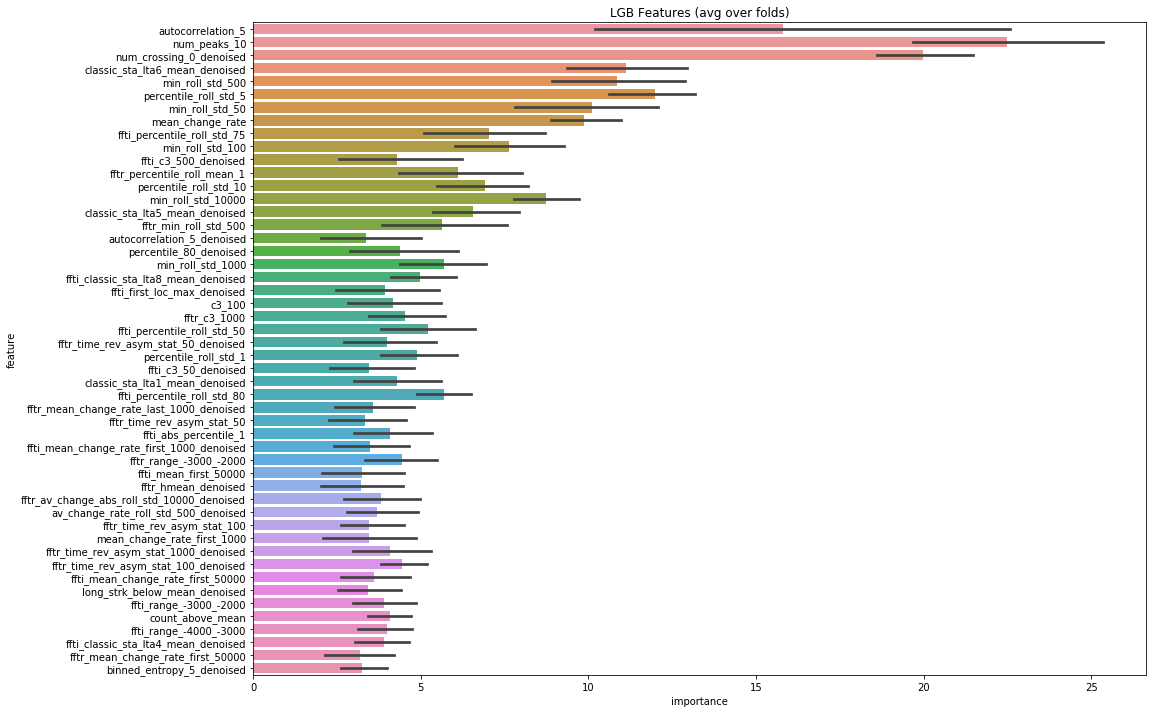

In [24]:
# https://chrisalbon.com/machine_learning/feature_selection/drop_highly_correlated_features/
corr_matrix = X.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.99)]
X = X.drop(to_drop, axis=1)
X_test = X_test.drop(to_drop, axis=1)
result_dict_lgb_lgb = artgor_utils.train_model_regression(X, X_test, y, params=params, folds=folds, model_type='lgb', plot_feature_importance=True)

In [25]:
# submission['time_to_failure'] = result_dict_lgb['prediction']
# submission.to_csv('submission_no_corr.csv')

**Important**: from now I'll use the reduced dataset - without highly correlated features.

### RFE


**Important notice**:  I run the cell below in `version 18` and printed the scores_dict. In the following versions I'll use `scores_dict` and plot the results instead of running feature selection each time

In [26]:
# %%time
# scores_dict = {'rfe_score': [], 'n_features': []}
# for i in np.arange(10, 1958, 100)[:3]:
#     print(i)
#     s1 = RFE(model, i, step=100)
#     X_train1 = s1.fit_transform(X, y.values.astype(int))
#     X_test1 = s1.transform(X_test)
#     result_dict_lgb = artgor_utils.train_model_regression(X_train1, X_test1, y.values.reshape(-1, ), params=params, folds=folds, model_type='lgb', plot_feature_importance=False)
#     scores_dict['rfe_score'].append(np.mean(result_dict_lgb['scores']))
    
#     scores_dict['n_features'].append(X_train1.shape[1])

In [27]:
scores_dict = {'rfe_score': [2.103586938061856, 2.052535910798748, 2.053228199447811], 'n_features': [10, 110, 210]}

In [28]:
scores_df = pd.DataFrame(scores_dict)
scores_df = scores_df.melt(id_vars=['n_features'], value_vars=['rfe_score'], var_name='metric', value_name='mae')
max_value = scores_df['mae'].max() * 1.05
min_value = scores_df['mae'].min() * 0.95
artgor_utils.render(alt.Chart(scores_df).mark_line().encode(
    y=alt.Y('mae:Q', scale=alt.Scale(domain=(min_value, max_value))),
    x='n_features:O',
    color='metric:N',
    tooltip=['metric:N', 'n:O', 'mae:Q']
).properties(
    title='Top N features by RFE vs CV'
).interactive())

## Model comparison

In this section I'll try variuos sklearn models and compair their score. Running GridSearchCV each time is too long, so I'll run it once for each model and use optimal parameters.

In [29]:
%%time
rfr = RandomForestRegressor()

# parameter_grid = {'n_estimators': [50, 60],
#                   'max_depth': [5, 10]
#                  }

# grid_search = GridSearchCV(rfr, param_grid=parameter_grid, cv=folds, scoring='neg_mean_absolute_error', n_jobs=-1)
# grid_search.fit(X, y)
# print('Best score: {}'.format(grid_search.best_score_))
# print('Best parameters: {}'.format(grid_search.best_params_))
# rfr = RandomForestRegressor(**grid_search.best_params_)
rfr = RandomForestRegressor(n_estimators=50, max_depth=5)
result_dict_rfr = artgor_utils.train_model_regression(X, X_test, y, params=params, folds=folds, model_type='sklearn', model=rfr)
# print(scores_rfr)

Fold 1 started at Thu May 23 16:05:04 2019
Fold 0. mae: 1.9885.

Fold 2 started at Thu May 23 16:05:32 2019
Fold 1. mae: 2.1416.

Fold 3 started at Thu May 23 16:06:00 2019
Fold 2. mae: 2.0849.

Fold 4 started at Thu May 23 16:06:27 2019
Fold 3. mae: 2.1467.

Fold 5 started at Thu May 23 16:06:55 2019
Fold 4. mae: 2.0840.

Fold 6 started at Thu May 23 16:07:22 2019
Fold 5. mae: 2.0594.

Fold 7 started at Thu May 23 16:07:50 2019
Fold 6. mae: 2.1482.

Fold 8 started at Thu May 23 16:08:17 2019
Fold 7. mae: 2.1344.

Fold 9 started at Thu May 23 16:08:45 2019
Fold 8. mae: 2.0624.

Fold 10 started at Thu May 23 16:09:12 2019
Fold 9. mae: 2.1513.

CV mean score: 2.1001, std: 0.0510.
CPU times: user 4min 35s, sys: 386 ms, total: 4min 36s
Wall time: 4min 36s


In [30]:
%%time
linreg = linear_model.LinearRegression(normalize=False, copy_X=True, n_jobs=-1)

result_dict_linreg = artgor_utils.train_model_regression(X, X_test, y, params=None, folds=folds, model_type='sklearn', model=linreg)
# print(scores_linreg)

Fold 1 started at Thu May 23 16:09:40 2019
Fold 0. mae: 2.6755.

Fold 2 started at Thu May 23 16:09:41 2019
Fold 1. mae: 4.7822.

Fold 3 started at Thu May 23 16:09:41 2019
Fold 2. mae: 2.3102.

Fold 4 started at Thu May 23 16:09:42 2019
Fold 3. mae: 2.5207.

Fold 5 started at Thu May 23 16:09:42 2019
Fold 4. mae: 7.2214.

Fold 6 started at Thu May 23 16:09:43 2019
Fold 5. mae: 3.5239.

Fold 7 started at Thu May 23 16:09:44 2019
Fold 6. mae: 3.7986.

Fold 8 started at Thu May 23 16:09:44 2019
Fold 7. mae: 4.9745.

Fold 9 started at Thu May 23 16:09:45 2019
Fold 8. mae: 4.9993.

Fold 10 started at Thu May 23 16:09:46 2019
Fold 9. mae: 2.6310.

CV mean score: 3.9437, std: 1.4780.
CPU times: user 43 s, sys: 31 s, total: 1min 13s
Wall time: 6.53 s


In [31]:
%%time
ridge = linear_model.Ridge(normalize=True)

parameter_grid = {'alpha': [0.1, 1.0, 10.0]}

grid_search = GridSearchCV(ridge, param_grid=parameter_grid, cv=folds, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_search.fit(X, y)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))
ridge = linear_model.Ridge(**grid_search.best_params_, normalize=True)
result_dict_ridge = artgor_utils.train_model_regression(X, X_test, y, params=params, folds=folds, model_type='sklearn', model=ridge)
# print(scores_ridge)

Best score: -5.204613637884696
Best parameters: {'alpha': 10.0}
Fold 1 started at Thu May 23 16:09:54 2019
Fold 0. mae: 2.0881.

Fold 2 started at Thu May 23 16:09:54 2019
Fold 1. mae: 2.2474.

Fold 3 started at Thu May 23 16:09:55 2019
Fold 2. mae: 2.1768.

Fold 4 started at Thu May 23 16:09:55 2019
Fold 3. mae: 2.1667.

Fold 5 started at Thu May 23 16:09:55 2019
Fold 4. mae: 2.1697.

Fold 6 started at Thu May 23 16:09:56 2019
Fold 5. mae: 2.1216.

Fold 7 started at Thu May 23 16:09:56 2019
Fold 6. mae: 32.4006.

Fold 8 started at Thu May 23 16:09:57 2019
Fold 7. mae: 2.2373.

Fold 9 started at Thu May 23 16:09:57 2019
Fold 8. mae: 2.1991.

Fold 10 started at Thu May 23 16:09:57 2019
Fold 9. mae: 2.2679.

CV mean score: 5.2075, std: 9.0645.
CPU times: user 19.5 s, sys: 16.8 s, total: 36.3 s
Wall time: 11.4 s


In [32]:
%%time
knn = neighbors.KNeighborsRegressor()

parameter_grid = {'n_neighbors': [50, 100]}

grid_search = GridSearchCV(knn, param_grid=parameter_grid, cv=folds, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_search.fit(X, y)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))
knn = neighbors.KNeighborsRegressor(**grid_search.best_params_)
result_dict_knn = artgor_utils.train_model_regression(X, X_test, y, params=params, folds=folds, model_type='sklearn', model=knn)

Best score: -2.3847527671638673
Best parameters: {'n_neighbors': 100}
Fold 1 started at Thu May 23 16:10:04 2019
Fold 0. mae: 2.2337.

Fold 2 started at Thu May 23 16:10:06 2019
Fold 1. mae: 2.4406.

Fold 3 started at Thu May 23 16:10:07 2019
Fold 2. mae: 2.3578.

Fold 4 started at Thu May 23 16:10:08 2019
Fold 3. mae: 2.3977.

Fold 5 started at Thu May 23 16:10:09 2019
Fold 4. mae: 2.4072.

Fold 6 started at Thu May 23 16:10:10 2019
Fold 5. mae: 2.2861.

Fold 7 started at Thu May 23 16:10:12 2019
Fold 6. mae: 2.3924.

Fold 8 started at Thu May 23 16:10:13 2019
Fold 7. mae: 2.4558.

Fold 9 started at Thu May 23 16:10:14 2019
Fold 8. mae: 2.4416.

Fold 10 started at Thu May 23 16:10:15 2019
Fold 9. mae: 2.4349.

CV mean score: 2.3848, std: 0.0692.
CPU times: user 12.1 s, sys: 807 ms, total: 12.9 s
Wall time: 18.5 s


In [33]:
%%time
lasso = linear_model.Lasso(normalize=True)

parameter_grid = {'alpha': [0.1, 1.0, 10.0]}

grid_search = GridSearchCV(lasso, param_grid=parameter_grid, cv=folds, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_search.fit(X, y)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))
lasso = linear_model.Lasso(**grid_search.best_params_, normalize=True)
result_dict_lasso = artgor_utils.train_model_regression(X, X_test, y, params=params, folds=folds, model_type='sklearn', model=lasso)

Best score: -3.049058724283343
Best parameters: {'alpha': 0.1}
Fold 1 started at Thu May 23 16:10:21 2019
Fold 0. mae: 2.9440.

Fold 2 started at Thu May 23 16:10:22 2019
Fold 1. mae: 3.0047.

Fold 3 started at Thu May 23 16:10:22 2019
Fold 2. mae: 3.0434.

Fold 4 started at Thu May 23 16:10:22 2019
Fold 3. mae: 2.9317.

Fold 5 started at Thu May 23 16:10:23 2019
Fold 4. mae: 3.1304.

Fold 6 started at Thu May 23 16:10:23 2019
Fold 5. mae: 3.0385.

Fold 7 started at Thu May 23 16:10:24 2019
Fold 6. mae: 3.1886.

Fold 8 started at Thu May 23 16:10:24 2019
Fold 7. mae: 2.9608.

Fold 9 started at Thu May 23 16:10:24 2019
Fold 8. mae: 3.1339.

Fold 10 started at Thu May 23 16:10:25 2019
Fold 9. mae: 3.1153.

CV mean score: 3.0491, std: 0.0851.
CPU times: user 12.8 s, sys: 11.6 s, total: 24.3 s
Wall time: 9.05 s


In [34]:
%%time
etr = ExtraTreesRegressor()

# parameter_grid = {'n_estimators': [500, 1000],
#                   'max_depth': [5, 10, 20]
#                  }

# grid_search = GridSearchCV(rfr, param_grid=parameter_grid, cv=folds, scoring='neg_mean_absolute_error', n_jobs=-1)
# grid_search.fit(X, y)
# print('Best score: {}'.format(grid_search.best_score_))
# print('Best parameters: {}'.format(grid_search.best_params_))
# etr = ExtraTreesRegressor(**grid_search.best_params_)
etr = ExtraTreesRegressor(n_estimators=1000, max_depth=10)
result_dict_etr = artgor_utils.train_model_regression(X, X_test, y, params=params, folds=folds, model_type='sklearn', model=etr)

Fold 1 started at Thu May 23 16:10:25 2019
Fold 0. mae: 1.9864.

Fold 2 started at Thu May 23 16:12:56 2019
Fold 1. mae: 2.1534.

Fold 3 started at Thu May 23 16:15:26 2019
Fold 2. mae: 2.0776.

Fold 4 started at Thu May 23 16:17:57 2019
Fold 3. mae: 2.1384.

Fold 5 started at Thu May 23 16:20:27 2019
Fold 4. mae: 2.0749.

Fold 6 started at Thu May 23 16:22:57 2019
Fold 5. mae: 2.0303.

Fold 7 started at Thu May 23 16:25:27 2019
Fold 6. mae: 2.1253.

Fold 8 started at Thu May 23 16:27:57 2019
Fold 7. mae: 2.1522.

Fold 9 started at Thu May 23 16:30:26 2019
Fold 8. mae: 2.0616.

Fold 10 started at Thu May 23 16:32:57 2019
Fold 9. mae: 2.1335.

CV mean score: 2.0934, std: 0.0536.
CPU times: user 25min 1s, sys: 846 ms, total: 25min 2s
Wall time: 25min 1s


In [35]:
%%time
adr = AdaBoostRegressor()

parameter_grid = {'n_estimators': [10, 50],
                 }

grid_search = GridSearchCV(adr, param_grid=parameter_grid, cv=folds, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_search.fit(X, y)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))
adr = AdaBoostRegressor(**grid_search.best_params_)
result_dict_adr = artgor_utils.train_model_regression(X, X_test, y, params=params, folds=folds, model_type='sklearn', model=adr)

Best score: -2.206992516576341
Best parameters: {'n_estimators': 10}
Fold 1 started at Thu May 23 16:36:10 2019
Fold 0. mae: 2.0944.

Fold 2 started at Thu May 23 16:36:15 2019
Fold 1. mae: 2.2759.

Fold 3 started at Thu May 23 16:36:21 2019
Fold 2. mae: 2.2096.

Fold 4 started at Thu May 23 16:36:26 2019
Fold 3. mae: 2.1489.

Fold 5 started at Thu May 23 16:36:31 2019
Fold 4. mae: 2.2458.

Fold 6 started at Thu May 23 16:36:36 2019
Fold 5. mae: 2.1559.

Fold 7 started at Thu May 23 16:36:42 2019
Fold 6. mae: 2.2766.

Fold 8 started at Thu May 23 16:36:47 2019
Fold 7. mae: 2.2192.

Fold 9 started at Thu May 23 16:36:52 2019
Fold 8. mae: 2.2225.

Fold 10 started at Thu May 23 16:36:58 2019
Fold 9. mae: 2.2957.

CV mean score: 2.2145, std: 0.0612.
CPU times: user 58.6 s, sys: 776 ms, total: 59.3 s
Wall time: 1min 36s


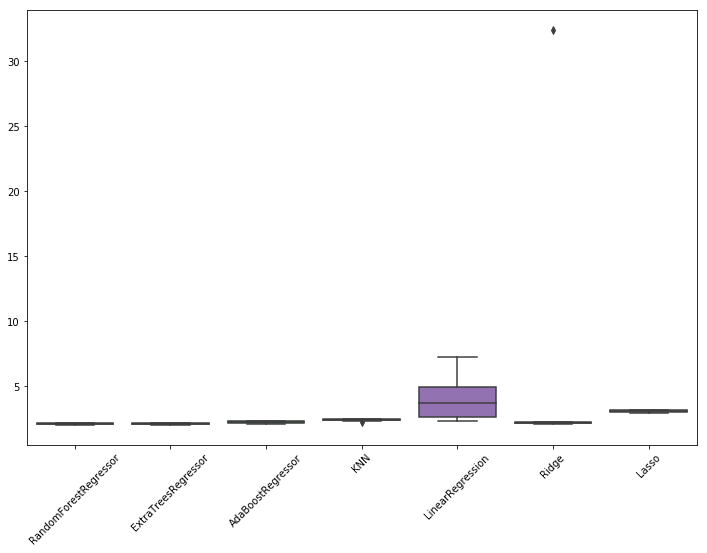

In [36]:
plt.figure(figsize=(12, 8));
scores_df = pd.DataFrame({'RandomForestRegressor': result_dict_rfr['scores']})
scores_df['ExtraTreesRegressor'] = result_dict_etr['scores']
scores_df['AdaBoostRegressor'] = result_dict_adr['scores']
scores_df['KNN'] = result_dict_knn['scores']
scores_df['LinearRegression'] = result_dict_linreg['scores']
scores_df['Ridge'] = result_dict_ridge['scores']
scores_df['Lasso'] = result_dict_lasso['scores']

sns.boxplot(data=scores_df);
plt.xticks(rotation=45);

## Blending

Let's try training and blending several models.

Fold 1 started at Thu May 23 16:37:03 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[606]	training's l1: 1.27009	valid_1's l1: 1.92767
Fold 2 started at Thu May 23 16:37:07 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1047]	training's l1: 0.929723	valid_1's l1: 2.07823
Fold 3 started at Thu May 23 16:37:13 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[739]	training's l1: 1.15053	valid_1's l1: 2.01202
Fold 4 started at Thu May 23 16:37:18 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[232]	training's l1: 1.69832	valid_1's l1: 2.067
Fold 5 started at Thu May 23 16:37:21 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[309]	training's l1: 1.59707	valid_1's l1: 2.05327
Fold 6 started at Thu May 23 16:37:24 20

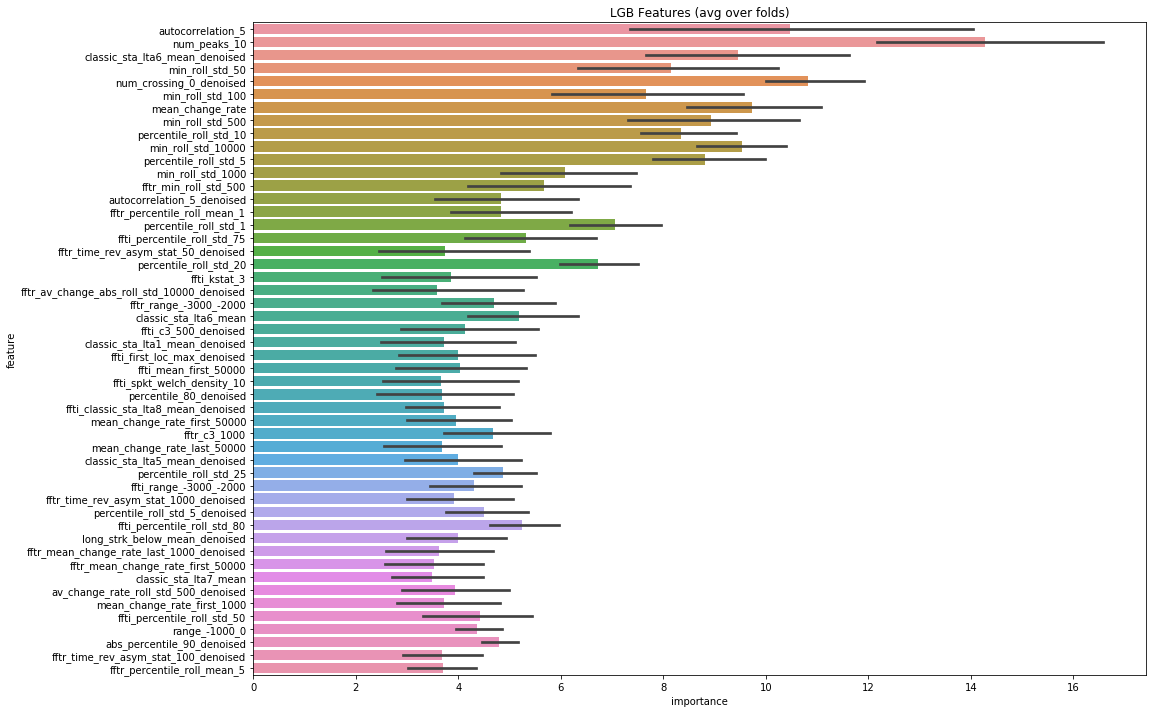

In [37]:
params = {'num_leaves': 128,
          'min_child_samples': 79,
          'objective': 'gamma',
          'max_depth': -1,
          'learning_rate': 0.01,
          "boosting_type": "gbdt",
          "subsample_freq": 5,
          "subsample": 0.9,
          "bagging_seed": 11,
          "metric": 'mae',
          "verbosity": -1,
          'reg_alpha': 0.1302650970728192,
          'reg_lambda': 0.3603427518866501,
          'colsample_bytree': 0.2
         }
result_dict_lgb = artgor_utils.train_model_regression(X=X, X_test=X_test, y=y, params=params, folds=folds, model_type='lgb',
                                                                                  eval_metric='mae', plot_feature_importance=True)

In [38]:
xgb_params = {'eta': 0.03,
              'max_depth': 9,
              'subsample': 0.85,
              'colsample_bytree': 0.3,
              'objective': 'reg:linear',
              'eval_metric': 'mae',
              'silent': True,
              'nthread': -1,
              'tree_method':'gpu_hist'
             }
result_dict_xgb = artgor_utils.train_model_regression(X=X, X_test=X_test, y=y, params=xgb_params, folds=folds, model_type='xgb')

Fold 1 started at Thu May 23 16:37:42 2019
[0]	train-mae:5.09243	valid_data-mae:4.78374
Multiple eval metrics have been passed: 'valid_data-mae' will be used for early stopping.

Will train until valid_data-mae hasn't improved in 200 rounds.
Stopping. Best iteration:
[86]	train-mae:0.804752	valid_data-mae:1.97811

Fold 2 started at Thu May 23 16:37:54 2019
[0]	train-mae:5.05823	valid_data-mae:5.0843
Multiple eval metrics have been passed: 'valid_data-mae' will be used for early stopping.

Will train until valid_data-mae hasn't improved in 200 rounds.
Stopping. Best iteration:
[75]	train-mae:0.922666	valid_data-mae:2.12843

Fold 3 started at Thu May 23 16:38:05 2019
[0]	train-mae:5.0601	valid_data-mae:5.06796
Multiple eval metrics have been passed: 'valid_data-mae' will be used for early stopping.

Will train until valid_data-mae hasn't improved in 200 rounds.
Stopping. Best iteration:
[85]	train-mae:0.814563	valid_data-mae:2.04208

Fold 4 started at Thu May 23 16:38:16 2019
[0]	train-m

In [39]:
submission['time_to_failure'] = (result_dict_lgb['prediction'] + result_dict_etr['prediction'] + result_dict_xgb['prediction']) / 3
print(submission.head())
submission.to_csv('blending.csv')

              time_to_failure
seg_id                       
seg_00030f  4.138666430505627
seg_0012b5  4.938864830411032
seg_00184e  5.764936326462262
seg_003339  8.405575528608638
seg_0042cc  7.017549003891531


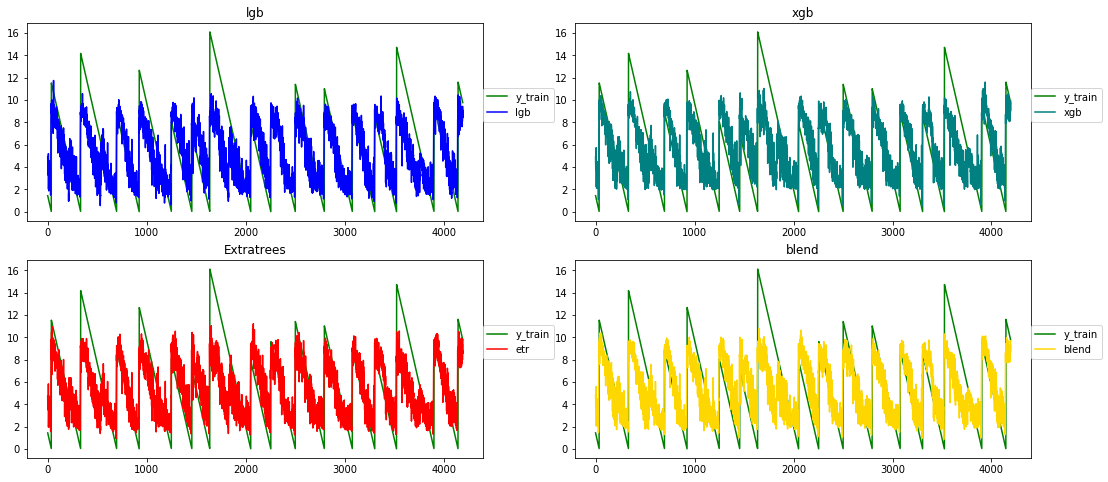

In [40]:
plt.figure(figsize=(18, 8))
plt.subplot(2, 2, 1)
plt.plot(y, color='g', label='y_train')
plt.plot(result_dict_lgb['oof'], color='b', label='lgb')
plt.legend(loc=(1, 0.5));
plt.title('lgb');
plt.subplot(2, 2, 2)
plt.plot(y, color='g', label='y_train')
plt.plot(result_dict_etr['oof'], color='teal', label='xgb')
plt.legend(loc=(1, 0.5));
plt.title('xgb');
plt.subplot(2, 2, 3)
plt.plot(y, color='g', label='y_train')
plt.plot(result_dict_xgb['oof'], color='red', label='etr')
plt.legend(loc=(1, 0.5));
plt.title('Extratrees');
plt.subplot(2, 2, 4)
plt.plot(y, color='g', label='y_train')
plt.plot((result_dict_lgb['oof'] + result_dict_etr['oof'] + result_dict_xgb['oof']) / 3, color='gold', label='blend')
plt.legend(loc=(1, 0.5));
plt.title('blend');

## Stacking

In [41]:
train_stack = np.vstack([result_dict_rfr['oof'], result_dict_ridge['oof'], result_dict_knn['oof'], result_dict_lasso['oof'], result_dict_etr['oof'],
                         result_dict_adr['oof'], result_dict_lgb['oof'], result_dict_xgb['oof'], result_dict_etr['oof']]).transpose()
train_stack = pd.DataFrame(train_stack, columns=['rfr', 'ridge', 'knn', 'lasso', 'etr', 'adr', 'lgb', 'xgb', 'etr'])

test_stack = np.vstack([result_dict_rfr['prediction'], result_dict_ridge['prediction'], result_dict_knn['prediction'], result_dict_lasso['prediction'], result_dict_etr['prediction'],
                        result_dict_adr['prediction'], result_dict_lgb['prediction'], result_dict_xgb['prediction'], result_dict_etr['prediction']]).transpose()
test_stack = pd.DataFrame(test_stack, columns=['rfr', 'ridge', 'knn', 'lasso', 'etr', 'adr', 'lgb', 'xgb', 'etr'])

In [42]:
params = {'num_leaves': 8,
         #'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 2,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
        # "lambda_l1": 0.2,
         "verbosity": -1}
result_dict_lgb_stack = artgor_utils.train_model_regression(X=train_stack, X_test=test_stack, y=y, params=params, folds=folds, model_type='lgb',
                                                                                  eval_metric='mae', plot_feature_importance=False,
                                                            columns=(list(train_stack.columns)))

Fold 1 started at Thu May 23 16:39:48 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[364]	training's rmse: 2.63664	training's l1: 2.06673	valid_1's rmse: 2.5536	valid_1's l1: 1.96381
Fold 2 started at Thu May 23 16:39:48 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[252]	training's rmse: 2.63045	training's l1: 2.06622	valid_1's rmse: 2.75887	valid_1's l1: 2.12464
Fold 3 started at Thu May 23 16:39:48 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1202]	training's rmse: 2.58011	training's l1: 2.00612	valid_1's rmse: 2.55686	valid_1's l1: 2.03812
Fold 4 started at Thu May 23 16:39:48 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[251]	training's rmse: 2.64019	training's l1: 2.07023	valid_1's rmse: 2.69803	valid_1's l1: 2.12011
Fold 5 started at Thu May 23 16:39:4

In [43]:
submission['time_to_failure'] = result_dict_lgb_stack['prediction']
print(submission.head())
submission.to_csv('stacking.csv')

              time_to_failure
seg_id                       
seg_00030f  4.395272600965439
seg_0012b5  5.310821347613286
seg_00184e  6.129032994578684
seg_003339  8.577645978822385
seg_0042cc  7.423738075543673
